In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [412]:
# Load data from text file
Status = np.loadtxt("Status_2024_05_31_causal_2.txt", dtype=int)  # Specify dtype if known, for efficiency
Target = np.loadtxt("Target_2024_05_31_causal_2.txt", dtype=float).T

In [413]:
N=Status.shape[0]

In [414]:
Target_train=torch.tensor(Target[30000:40000,:]).float()
Target_test=torch.tensor(Target[30000:40000,:]).float()
Target_val=torch.tensor(Target[40000:50000,:]).float()
print(Target_train.shape,Target_test.shape,Target_val.shape)

torch.Size([10000, 10]) torch.Size([10000, 10]) torch.Size([10000, 10])


Notice that:
1. Each row of above X matrice is the vector of status of node 1 to node T
2. Each row of above Y is the status of node T+1

Then we need to construct word embedding and positional encoding

$$\tilde{X}^T=\begin{bmatrix}
    e_{s_1}& e_{s_2}&\cdots&e_{s_T}\\
    e_1&e_2&\cdots&e_T
\end{bmatrix}=\begin{bmatrix}
    \mathcal{E}_{s_{1:T}}\\
    \mathbb{I}_{T}
\end{bmatrix}$$

Generate $\mathbb{I}_{T}$ and $\mathcal{E}_{s_{1:T}}$

The input of Transformer should be $\tilde{X}^T$ and the output is $\pi(s'|s_T)$

#### Construct the input

In [415]:
S=10
T=20

#number of random sequence


I_S=np.identity(S)
I_t=np.identity(T)

#(iter,S+T,T)
X_tilde_T=np.empty((N,S+T,T))


for i in range(N):

    epsilon_1_T=np.zeros((S,T))

    #print(T)

    for k in range(T):
        epsilon_1_T[:,int(k)]=I_S[:,int(Status[i,int(k)])]

    #print(Status[0])

    X_tilde_T[i]=np.concatenate((epsilon_1_T,I_t),axis=0)


X_tilde=X_tilde_T.transpose(0,2,1)



X_train_tilde=torch.tensor(X_tilde[30000:40000])
X_test_tilde=torch.tensor(X_tilde[30000:40000])
X_val_tilde=torch.tensor(X_tilde[40000:50000])

X_train_tilde.to(device)
X_test_tilde.to(device)
X_val_tilde.to(device)

print(X_train_tilde.shape)
print(X_test_tilde.shape)

torch.Size([10000, 20, 30])
torch.Size([10000, 20, 30])


In [416]:
batch_size=100

train_dataset=TensorDataset(torch.tensor(X_train_tilde).float(),torch.tensor(Target_train).float())
train_data=DataLoader(train_dataset,batch_size=batch_size)

# test_dataset=TensorDataset(torch.tensor(X_test_tilde).float(),torch.tensor(Target_test).float())
# test_data=DataLoader(test_dataset,batch_size=batch_size)

/tmp/ipykernel_84582/36373231.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset=TensorDataset(torch.tensor(X_train_tilde).float(),torch.tensor(Target_train).float())


In [417]:
a, a_label = next(iter(train_data))

In [418]:
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([100, 20, 30])
torch.Size([100, 10])


#### Construct the target

$$
\begin{equation*}
    \begin{split}
        \tilde A^{(1)}&=\begin{bmatrix}
            0_{S\times S} & 0_{S\times T}\\
            0_{T\times S} & A^{(1)}_1
        \end{bmatrix}\\
        % \tilde A_2^{(1)}&=\begin{bmatrix}
        %     0_{S\times S} & 0_{S\times T}\\
        %     0_{T\times S} & A^{(1)}_2
        % \end{bmatrix}\\
        \tilde A^{(2)}&=\begin{bmatrix}
            0_{S\times S} & 0_{S\times T} & A^{(2)} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T} & 0_{T\times S} & 0_{T\times T}\\
            0_{S\times S} & 0_{S\times T} & 0_{S\times S} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T} & 0_{T\times S} & 0_{T\times T}\\
        \end{bmatrix}\\
    \end{split}
\end{equation*}
$$

$$
attn(h;A)=\mathcal{S}(MASK(hAh^T))h
$$

$$
\underset{T\times (S+T)}{h^{0}}=\tilde{X}=\begin{bmatrix}
    e_{s_1}& e_{s_2}&\cdots&e_{s_T}\\
    e_1&e_2&\cdots&e_T
\end{bmatrix}^T
$$

$$
\underset{T\times (1+m_\ell)(S+T)}{h^{(\ell)}}=\bigl[h^{(\ell-1)},attn(h^{(\ell-1)};\widetilde{A}^{(\ell)}_1),\cdots,attn(h^{(\ell-1)};\widetilde{A}^{(\ell)}_1)\bigr]
$$

$$
\widetilde{TF}_{\tilde\theta}(S_{1:T})=h^{(L)}\widetilde {W}_O^T
$$

$$
dim(\widetilde {W}_O)=S\times (1+m_2)(S+T)
$$

In [434]:
mask_layer_1=torch.triu(torch.ones(T, T, dtype=torch.bool), diagonal=1).to(device)

a_1=-5

a_2=0
b_2=0
c_2=0
d_2=-1

class Attention_1(nn.Module):
    def __init__(self):
        super(Attention_1, self).__init__()

        self.part_1_1=nn.Parameter(torch.ones(1), requires_grad=False)
        self.part_1_2=nn.Parameter(torch.zeros(T), requires_grad=False)

        self.part_2_1 = nn.Parameter(torch.zeros(T), requires_grad=True)
        self.part_2_2 = nn.Parameter(torch.zeros(T, T), requires_grad=True)

    def forward(self, h_0,attn_mask):
        
        
        
        
        temp_1=torch.cat((a_1*self.part_1_1*torch.eye(S).cuda(),
                          torch.outer(torch.ones(S).cuda(),self.part_1_2)),dim=1)
        
        temp_2=torch.cat((torch.outer(self.part_2_1,torch.ones(S).cuda()),self.part_2_2),dim=1)
        
        total_matrix_A_1=torch.cat((temp_1,temp_2),dim=0)
        
        
        
        
        
        
        h_0=h_0.float()

        total_matrix_A_1=total_matrix_A_1.unsqueeze(0)
        total_matrix_A_1=total_matrix_A_1.repeat(h_0.shape[0],1,1)

        # print(total_matrix_A_1.shape, h_0.shape)

        scores = torch.bmm(h_0, total_matrix_A_1) 

        scores = torch.bmm(scores,h_0.transpose(1,2))
        # print(scores.shape)

        attn_mask = attn_mask.unsqueeze(0)
        attn_mask = attn_mask.repeat(scores.shape[0],1,1)

        

        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        #row-wise softmax
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.bmm(attn, h_0)
        # print('layer 1 output shape: ',context.shape)

        return context #, attn



class Attention_2(nn.Module):
    def __init__(self):
        super(Attention_2, self).__init__()
        
        self.part_1_1=nn.Parameter(torch.ones(1), requires_grad=True)
        self.part_1_2=nn.Parameter(torch.zeros(T), requires_grad=False)
        self.part_1_3=nn.Parameter(torch.ones(1), requires_grad=True)
        self.part_1_4=nn.Parameter(torch.zeros(T), requires_grad=False)
    
        
        self.part_2_1 = nn.Parameter(torch.zeros(T, S), requires_grad=False)
        self.part_2_2 = nn.Parameter(torch.zeros(T, T), requires_grad=True)
        self.part_2_3 = nn.Parameter(torch.zeros(T, S), requires_grad=False)
        self.part_2_4 = nn.Parameter(torch.zeros(T, T), requires_grad=True)

        self.part_3_1=nn.Parameter(torch.ones(1), requires_grad=True)
        self.part_3_2=nn.Parameter(torch.zeros(T), requires_grad=False)
        self.part_3_3=nn.Parameter(torch.ones(1), requires_grad=True)
        self.part_3_4=nn.Parameter(torch.zeros(T), requires_grad=False)
    
        
        self.part_4_1 = nn.Parameter(torch.zeros(T, S), requires_grad=False)
        self.part_4_2 = nn.Parameter(torch.zeros(T, T), requires_grad=False)
        self.part_4_3 = nn.Parameter(torch.zeros(T, S), requires_grad=False)
        self.part_4_4 = nn.Parameter(torch.zeros(T, T), requires_grad=False)


    def forward(self, h_1):
        
        
        
        temp_1=torch.cat((a_2*self.part_1_1*torch.eye(S).cuda(),
                         torch.outer(torch.ones(S).cuda(),
                         self.part_1_2),
                         d_2*self.part_1_3*torch.eye(S).cuda(),
                         torch.outer(torch.ones(S).cuda(),
                                     self.part_1_4)),dim=1)
                         
        temp_2=torch.cat((self.part_2_1,
                         self.part_2_2,
                         self.part_2_3,
                         self.part_2_4),
                         dim=1)
        
        temp_3=torch.cat((b_2*self.part_3_1*torch.eye(S).cuda(),
                 torch.outer(torch.ones(S).cuda(),
                 self.part_3_2),
                 c_2*self.part_3_3*torch.eye(S).cuda(),
                 torch.outer(torch.ones(S).cuda(),
                             self.part_3_4)),dim=1)
                         
        temp_4=torch.cat((self.part_4_1,
                         self.part_4_2,
                         self.part_4_3,
                         self.part_4_4),
                         dim=1)
        
        total_matrix_A_2=torch.cat((temp_1,temp_2,temp_3,temp_4),dim=0)



        
        h_1=h_1.float()
        
        total_matrix_A_2=total_matrix_A_2.unsqueeze(0)
        total_matrix_A_2=total_matrix_A_2.repeat(h_1.shape[0],1,1)
        #print("total_matrix_A_2_shape: ",total_matrix_A_2.shape)

        scores = torch.bmm(h_1, total_matrix_A_2) 
        scores = torch.bmm(scores,h_1.transpose(1,2))
        #row-wise softmax
        
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.bmm(attn, h_1)
        #print('layer 2 output shape: ',context.shape)
        
        return context #, attn

# class Weight_mat(nn.Module):
#     def __init__(self):
#         super(Weight_mat,self).__init__()
#         self.trainable_part = nn.Parameter(torch.eye(S, S),requires_grad=False).cuda()
# #         self.trainable_part = torch.eye(S).cuda()
#         self.non_trainable_part_1 = torch.zeros((2*S+2*T), S, requires_grad=False).cuda()
#         self.non_trainable_part_2 = torch.zeros((S+2*T), S, requires_grad=False).cuda()

#     def forward(self,X):
#         W_tilde_T=torch.cat((self.non_trainable_part_1,self.trainable_part,self.non_trainable_part_2),dim=0).to(device)
#         return W_tilde_T
        

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.attention_1 = Attention_1()
        self.attention_2 = Attention_2()
        # self.linear = nn.Linear(2*S+2*T, 1)
        # self.W_tilde_T = nn.Parameter(torch.zeros(int(4*S+4*T), int(S)).float())
#         self.trainable_part = nn.Parameter(torch.zeros(S, S))
# #         self.trainable_part = torch.eye(S).cuda()
#         self.non_trainable_part_1 = torch.zeros((2*S+2*T), S, requires_grad=False).cuda()
#         self.non_trainable_part_2 = torch.zeros((S+2*T), S, requires_grad=False).cuda()
#         self.W_T=Weight_mat()
        
    
    def forward(self, X):
#         W_tilde_T=torch.cat((self.non_trainable_part_1,self.trainable_part,self.non_trainable_part_2),dim=0).to(device)
        
#         W_tilde_T=self.W_T(X)
        
#         print("W_T:",W_tilde_T[2*S+2*T:3*S+2*T])
        
        attn_mask = mask_layer_1
        context_1 = self.attention_1(X, attn_mask)
        # print('h_0 shape: ',X.shape)
        
#         print("context_1",context_1[0])
#         print("context_1 check", torch.sum(context_1[0],dim=-1))
#         print("context_1 shape", context_1.shape)
        
        h_1=torch.cat((X,context_1),dim=-1).float()
#         print("h_1", h_1[0])
#         print("h_1 shape", h_1[0].shape)
#         print("h_1 check", torch.sum(h_1[0],dim=-1))

        
        context_2 = self.attention_2(h_1)
#         print("context_2 shape",context_2.shape)
#         print("context_2", context_2[0])
#         print("context_2 check", context_2[0].sum(dim=-1))
        
        h_2=torch.cat((h_1,context_2),dim=-1).float()
#         print("h_2 shape", h_2.shape)
#         print("h_2",h_2[0,-1,60:70])
#         print("h_2 check", h_2[0,-1,60:70].sum())
        
        
        
#         output=torch.matmul(h_2[:,-1,:],W_tilde_T)
        output=h_2[:,-1,(2*S+2*T):(3*S+2*T)]
        #print('output shape: ',output.shape)
        
        return output#, W_tilde_T#,attn_1,attn_2

In [435]:
net=Transformer()
net.to(device)


criterion = nn.KLDivLoss(reduction='batchmean')

# trainable_params = [p for p in net.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(net.parameters(), lr=2)



In [436]:
for name,param in net.named_parameters():
    if 'attention_1' not in name:
        param.requires_grad=False

for name, param in net.named_parameters():
    print(f"{name} trainable: {param.requires_grad}")

attention_1.part_1_1 trainable: False
attention_1.part_1_2 trainable: False
attention_1.part_2_1 trainable: True
attention_1.part_2_2 trainable: True
attention_2.part_1_1 trainable: False
attention_2.part_1_2 trainable: False
attention_2.part_1_3 trainable: False
attention_2.part_1_4 trainable: False
attention_2.part_2_1 trainable: False
attention_2.part_2_2 trainable: False
attention_2.part_2_3 trainable: False
attention_2.part_2_4 trainable: False
attention_2.part_3_1 trainable: False
attention_2.part_3_2 trainable: False
attention_2.part_3_3 trainable: False
attention_2.part_3_4 trainable: False
attention_2.part_4_1 trainable: False
attention_2.part_4_2 trainable: False
attention_2.part_4_3 trainable: False
attention_2.part_4_4 trainable: False


In [437]:
# plt.imshow(parameters[0].detach().numpy(), cmap='hot')  # 'hot' is a popular colormap for heatmaps
# plt.colorbar()  # Show color scale

In [438]:
import torch.nn.functional as F

In [439]:
epoch_num=30000
scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epoch_num,eta_min=0.1)

In [440]:
import time
starttime = time.time()


# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

index=100

cnt=-index

In [441]:
for e in range(epoch_num):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        im=im.cuda()
        label=label.cuda()
        # im = Variable(im)
        # label = Variable(label)
        # 前向传播x

        out = net(im)
#         print(out[0,:])
#         print("out sum:", torch.sum(out[0,:]))
#         print(label[0,:])
#         print("label sum:", torch.sum(label[0,:]))
        out = F.log_softmax(out,dim=1)
        loss = criterion(out, label)
        
        
        
#         print(net.attention_1.trainable_part.grad)
        
        # 反向传播
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # 记录误差
        
        train_loss += loss.item()
    
    
    scheduler.step()
    
    current_lr=scheduler.get_last_lr()[0]
    
    if e%index==0:
        cnt+=index
        endtime = time.time()
        print('Epoch: {},Train Loss: {},Time: {}'.format(e,train_loss/len(train_data),endtime-starttime))
        print(f"Current learning rate: {current_lr}")
        
    losses.append(train_loss / len(train_data))
    


Epoch: 0,Train Loss: 1.2876042461395263,Time: 1.1854674816131592
Current learning rate: 1.999999994791042
Epoch: 100,Train Loss: 1.2847867166996003,Time: 71.90592217445374
Current learning rate: 1.9999468639160303
Epoch: 200,Train Loss: 1.2833708012104035,Time: 139.35108971595764
Current learning rate: 1.9997895606624616


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

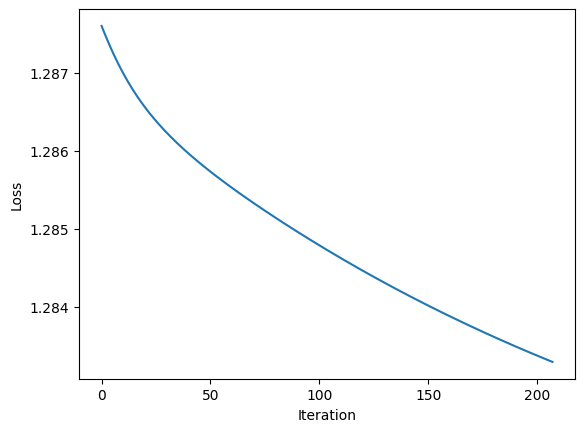

In [442]:
# Create a line plot of `losses`
plt.plot(losses)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [443]:
losses[-1]

1.2832902598381042

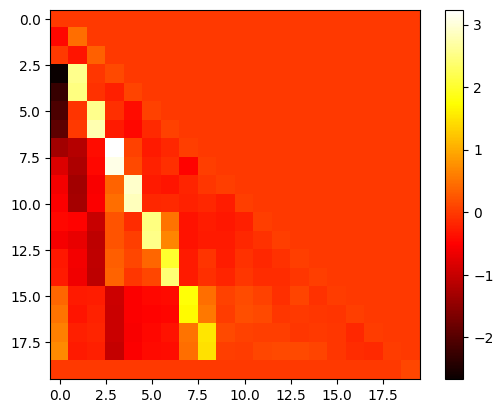

In [444]:
weight_fig=net.attention_1.part_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

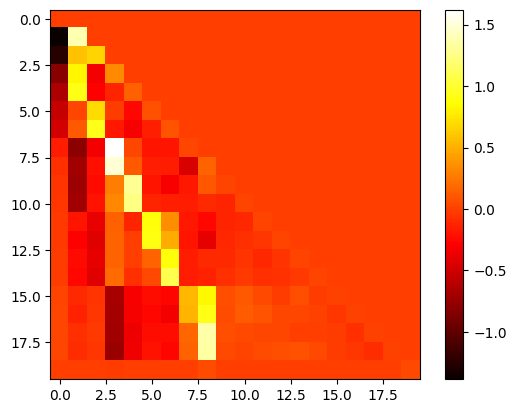

In [429]:
weight_fig=net.attention_1.part_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

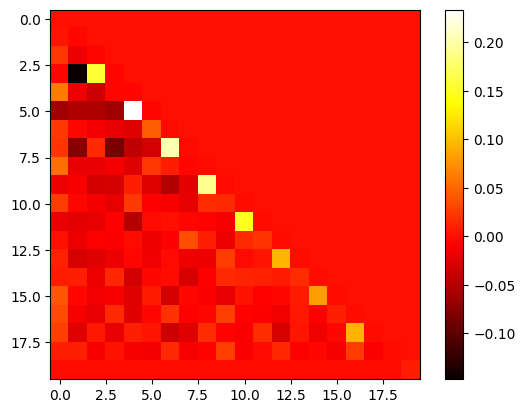

In [366]:
weight_fig=net.attention_1.part_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

In [367]:
net.attention_1.part_1_1.cpu().detach().numpy()

array([1.], dtype=float32)

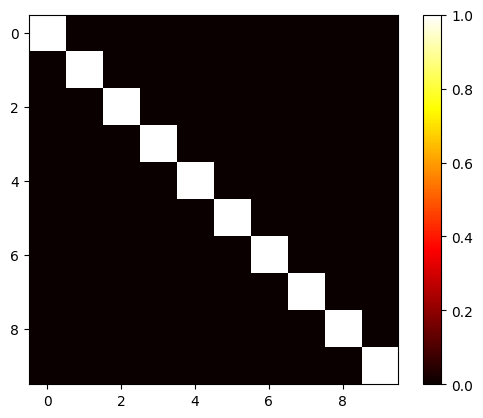

In [368]:
weight_fig=net.attention_1.part_1_1.cpu().detach().numpy()
plt.imshow(weight_fig*np.eye(S,S), cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

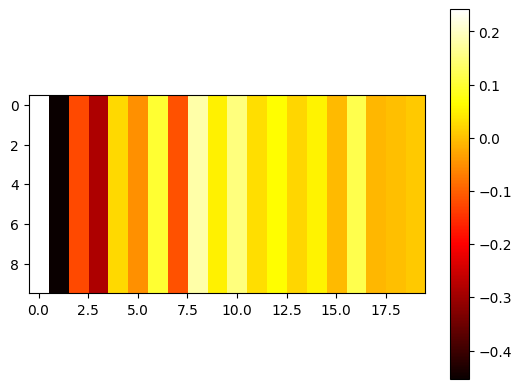

In [369]:
weight_fig=net.attention_1.part_1_2.cpu().detach().numpy()
plt.imshow(np.outer(np.ones(S),weight_fig), cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

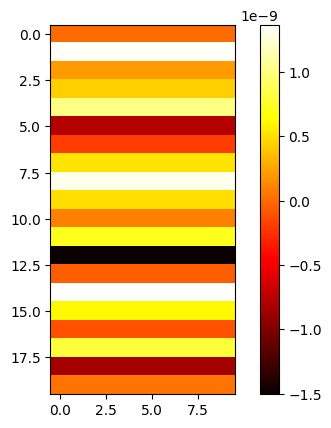

In [370]:
weight_fig=net.attention_1.part_2_1.cpu().detach().numpy()
plt.imshow(np.outer(weight_fig,np.ones(S)), cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

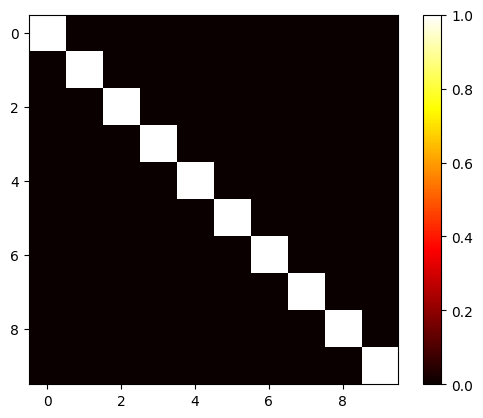

In [371]:
weight_fig=net.attention_2.part_1_1.cpu().detach().numpy()*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

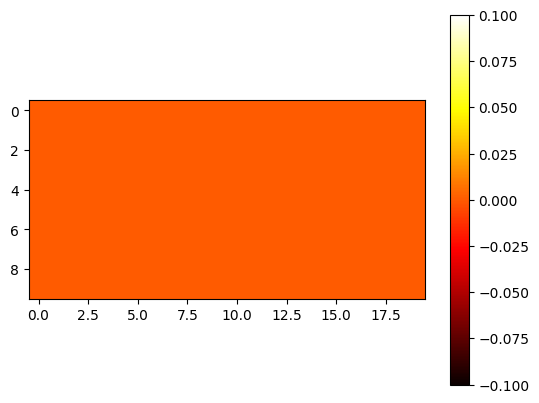

In [65]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_1_2.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

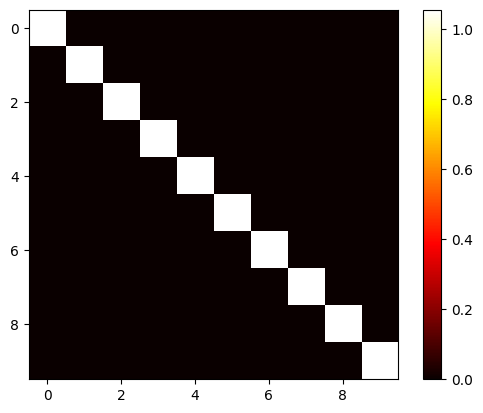

In [66]:
weight_fig=net.attention_2.part_1_3.cpu().detach().numpy()*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

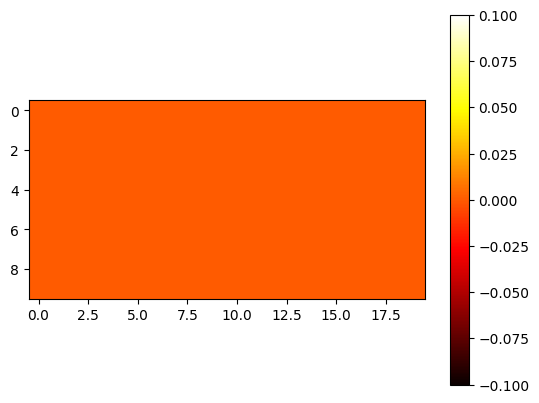

In [67]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_1_4.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

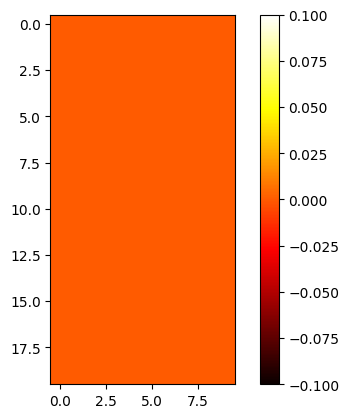

In [68]:
weight_fig=net.attention_2.part_2_1.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

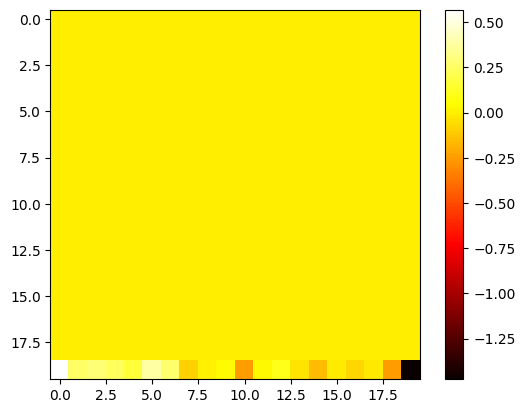

In [69]:
weight_fig=net.attention_2.part_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

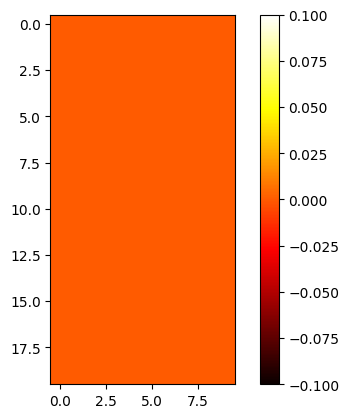

In [70]:
weight_fig=net.attention_2.part_2_3.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

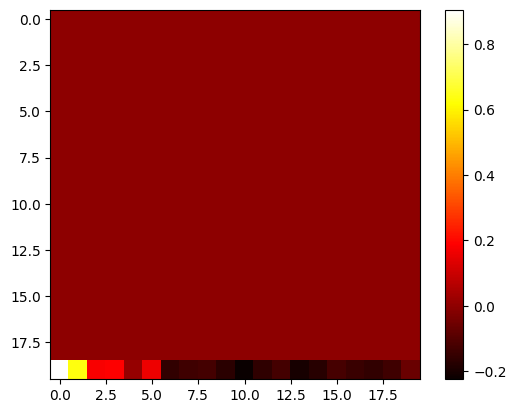

In [71]:
weight_fig=net.attention_2.part_2_4.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

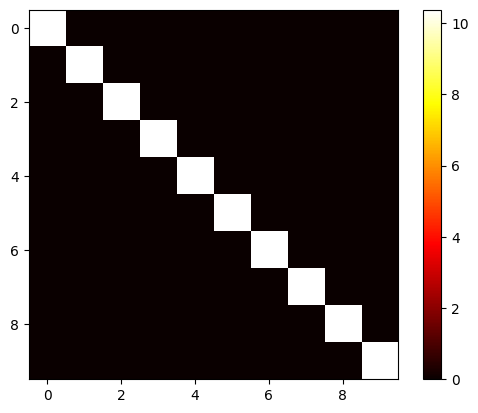

In [72]:
weight_fig=net.attention_2.part_3_1.cpu().detach().numpy()*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

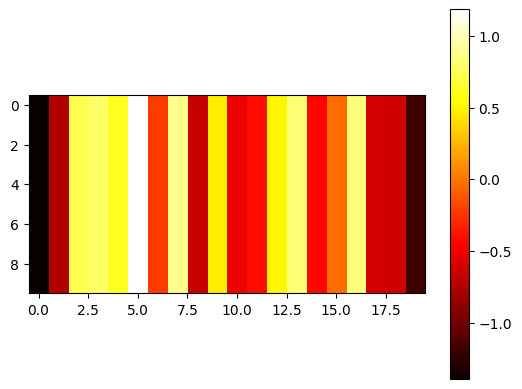

In [114]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_1_2.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

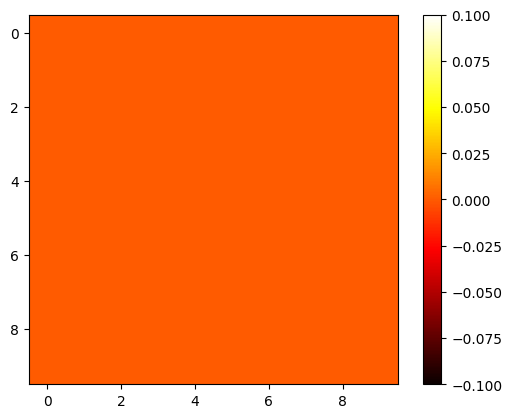

In [115]:
weight_fig=net.attention_2.part_3_3.cpu().detach().numpy()*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

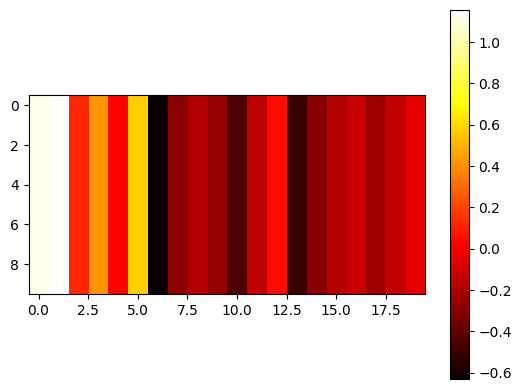

In [116]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_3_4.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

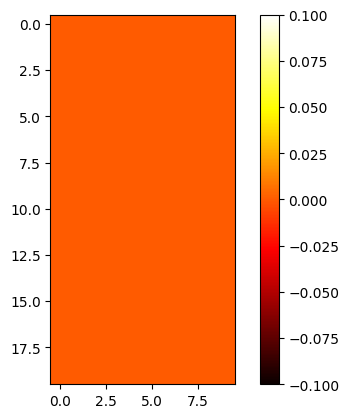

In [117]:
weight_fig=net.attention_2.part_4_1.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

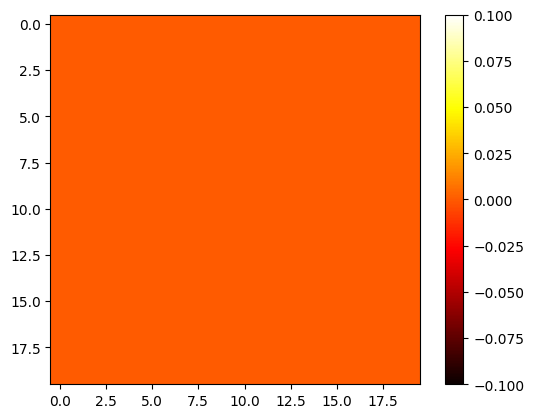

In [118]:
weight_fig=net.attention_2.part_4_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

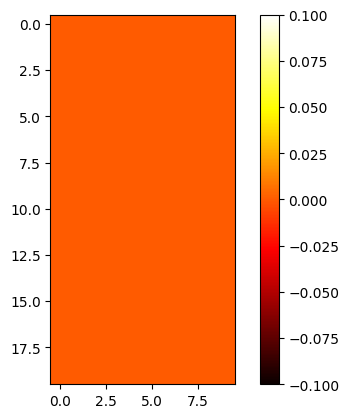

In [119]:
weight_fig=net.attention_2.part_4_3.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

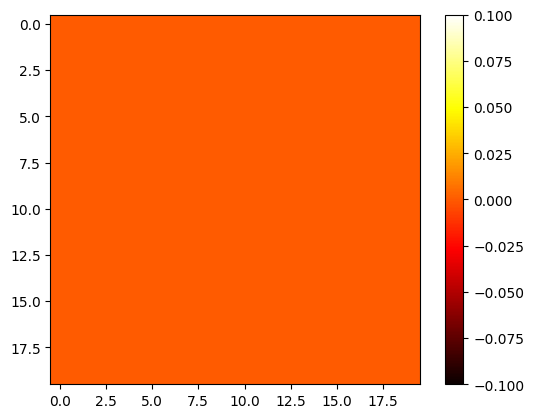

In [120]:
weight_fig=net.attention_2.part_4_4.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

In [86]:
# for j in range(20):
#     loss=np.empty(X_train_tilde.shape[0])
#     for i in range(X_train_tilde.shape[0]):
#         temp=net(X_train_tilde[i])[0][-1,:].float()+1e-6
#         loss[i]=-torch.matmul(Target_train[i],torch.log(temp))

#     Loss=sum(loss)/iter
#     print(Loss)

In [87]:
loss=np.empty(X_train_tilde.shape[0])
for i in range(X_train_tilde.shape[0]):
    temp=net(X_train_tilde[i])[0][-1,:].float()+1e-6
    loss[i]=-torch.matmul(Target_train[i],torch.log(temp))

Loss=sum(loss)/iter
print(Loss)

RuntimeError: Expected 3-dimensional tensor, but got 2-dimensional tensor for argument #1 'batch1' (while checking arguments for bmm)